In [4]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

## Data

In [5]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [6]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

## Preprocessing


In [7]:
zero_values_percentage_cutoff = 0.5 # no more than x% of data can be zeros
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-10-09 21:27:45.223742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 21:27:45.227479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 21:27:45.281842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 21:27:45.295812: I tensorflow/core/platform/cpu_featu

In [8]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## Features and targets

In [9]:
seq_length = 10
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

y_targets = pd.DataFrame(y_targets)
y_targets.columns = df.columns

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 506
Train sequences: 411
Test sequences: 95


In [10]:
y_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000238,0.229885,0.000957,0.120617,0.088737,0.005941,0.400000,0.264908,0.212963,...,0.428222,0.083333,0.008862,0.142857,0.104264,0.012304,0.161417,0.033675,0.274139,0.119601
1,0.000000,0.000290,0.206897,0.000957,0.123422,0.092150,0.005941,0.418182,0.253641,0.203704,...,0.530179,0.102564,0.005153,0.122449,0.136026,0.014765,0.169291,0.038503,0.294871,0.122924
2,0.024316,0.000307,0.206897,0.000478,0.118513,0.119454,0.005941,0.400000,0.256389,0.217593,...,0.636215,0.102564,0.005539,0.122449,0.129794,0.017379,0.177165,0.043935,0.315672,0.049834
3,0.024620,0.000256,0.195402,0.000478,0.117111,0.119454,0.007921,0.381818,0.181918,0.175926,...,0.663948,0.089744,0.005587,0.102041,0.139733,0.025531,0.165354,0.042728,0.278914,0.066445
4,0.040122,0.000221,0.172414,0.000478,0.093969,0.143345,0.015842,0.218182,0.044243,0.175926,...,0.665579,0.096154,0.002264,0.102041,0.106095,0.043064,0.129921,0.059264,0.205310,0.049834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
502,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
503,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
504,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## The model

In [11]:
def fetch_model():

    reg = 1e-8
    
    n_feats = len(df.columns)
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [12]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [10]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [14]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
loss.call(y_true, y_pred)

In [15]:
target_taxa = 181155

plot=False

if plot is True:
    plot_a_taxa_sequence(y_targets_train[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

Epoch 1/15


2023-10-09 21:27:54.793145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-09 21:27:54.828189: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f375865be50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 21:27:54.828233: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-09 21:27:54.832620: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 21:27:54.845097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-09 21:27:54.939108: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

13/13 [==============================] - 2s 31ms/step - loss: nan - mae: 0.0406 - mape: 53602.6719 - val_loss: 31.2773 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 2/15
13/13 [==============================] - 0s 16ms/step - loss: nan - mae: 0.0407 - mape: 93.3333 - val_loss: 29.4930 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 3/15
13/13 [==============================] - 0s 17ms/step - loss: nan - mae: 0.0407 - mape: 93.3333 - val_loss: 28.2306 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 4/15
13/13 [==============================] - 0s 17ms/step - loss: nan - mae: 0.0407 - mape: 93.3333 - val_loss: 27.3778 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 5/15
13/13 [==============================] - 0s 16ms/step - loss: nan - mae: 0.0407 - mape: 93.3333 - val_loss: 26.7977 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 6/15
13/13 [==============================] - 0s 17ms/step - loss: 6.5019 - mae: 0.0407 - mape: 93.3333 - val_loss: 26.3890 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 7/15
13/1

In [17]:
n_epochs = 15

loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
model = fetch_model()
model = compile_model(model, loss)

model.fit(x=X_sequences_train, y=y_targets_train[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              5025792   
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5616385 (21.42 MB)
Trainable params: 5616385 (21.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
y_pred = model.predict(X_sequences_test)

true_sequence = y_targets_test[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

NameError: name 'model' is not defined

## The Ensemble

In [14]:
class ensemble():
    
    def __init__(self, ensemble_name, loss, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            model = fetch_model()
            model = compile_model(model, loss)
            y_targets = y_targets_train[taxa_idx]
            model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
            
            model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
            del model
            
    
    def load(self):
        
        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            
            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
                 
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [15]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)

model_ensemble = ensemble(ensemble_name="test_ensemble", loss=loss, overwrite_on_train=True)

In [22]:
model_ensemble.train(X_sequences_train=X_sequences_train, y_targets_train=y_targets_train, n_epochs=15)

Overwriting an existing model dir


Training models: 100%|██████████| 202/202 [21:27<00:00,  6.38s/it]


## Valiadation

In [16]:
y_test_df = pd.DataFrame(y_targets_test)
y_test_df = y_test_df.reset_index(drop=True)
y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.058055,0.000324,0.022989,0.341627,0.513324,0.000000,0.003960,0.018182,0.019236,0.046296,...,0.011419,0.000000,0.097334,0.000000,0.000558,0.000461,0.000000,0.005794,0.027115,0.043189
1,0.066869,0.000307,0.068966,0.266986,0.513324,0.003413,0.003960,0.036364,0.020335,0.097222,...,0.017945,0.006410,0.093794,0.000000,0.000536,0.001692,0.000000,0.024019,0.087434,0.106312
2,0.068085,0.000290,0.091954,0.154545,0.394811,0.023891,0.001980,0.036364,0.025007,0.097222,...,0.022023,0.006410,0.020469,0.000000,0.000514,0.004460,0.027559,0.035003,0.185438,0.106312
3,0.068997,0.000290,0.149425,0.040191,0.152875,0.023891,0.001980,0.036364,0.033800,0.180556,...,0.027732,0.032051,0.032196,0.040816,0.000491,0.005691,0.035433,0.061316,0.275474,0.172757
4,0.037690,0.000017,0.229885,0.010048,0.000000,0.047782,0.001980,0.127273,0.078593,0.203704,...,0.051387,0.051282,0.018663,0.040816,0.000089,0.008305,0.039370,0.075075,0.478362,0.176080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
91,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
92,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
93,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


In [17]:
y_pred_df = model_ensemble.predict(X_sequences_test)
y_pred_df = y_pred_df.reset_index(drop=True)
y_pred_df.columns = y_test_df.columns

Predicting values: 100%|██████████| 202/202 [00:26<00:00,  7.50it/s]


In [18]:
y_pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048524,0.000000,0.074926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.143971,0.000000,0.117041,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007515
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222559,0.000000,0.159859,...,0.017236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029405
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205634,0.000000,0.152612,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040030
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163141,0.000000,0.153991,...,0.042456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.000000,0.000000,0.179140,0.000000,0.000000,0.101257,0.083051,0.307082,0.000000,0.148243,...,0.203481,0.000000,0.000000,0.000000,0.000000,0.157493,0.000000,0.110596,0.000000,0.248258
91,0.000000,0.000000,0.217742,0.000000,0.000000,0.116300,0.079098,0.365074,0.000000,0.181259,...,0.247375,0.000000,0.000000,0.000000,0.000000,0.167421,0.000000,0.106950,0.000000,0.263509
92,0.000000,0.000000,0.259412,0.000000,0.000000,0.139763,0.086352,0.436295,0.000000,0.225936,...,0.298391,0.000000,0.000000,0.000000,0.000000,0.197856,0.000000,0.119151,0.000000,0.281628
93,0.000000,0.000000,0.368091,0.000000,0.000000,0.168563,0.113509,0.526946,0.000000,0.279943,...,0.439987,0.000000,0.000000,0.000000,0.000000,0.248684,0.000000,0.172211,0.000000,0.311239


In [19]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 122, 60.396039603960396% of all taxa


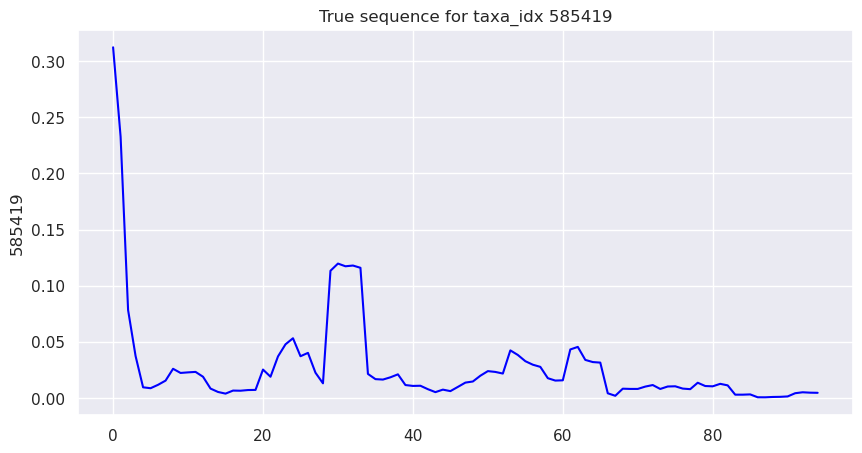

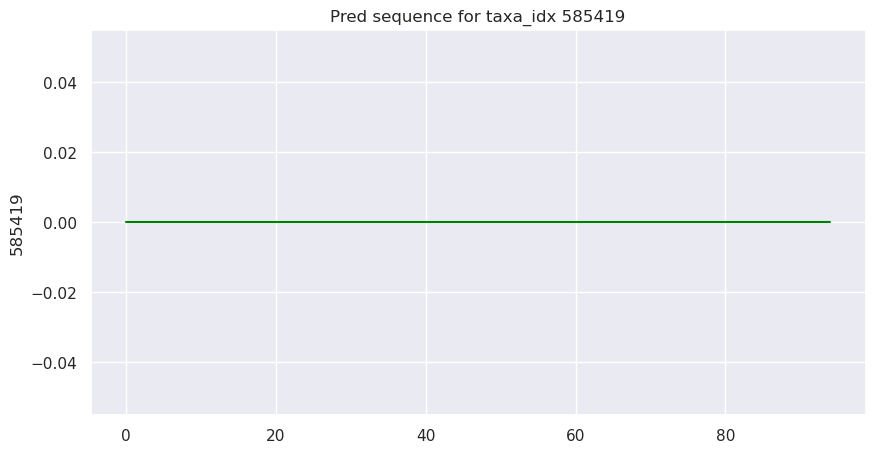

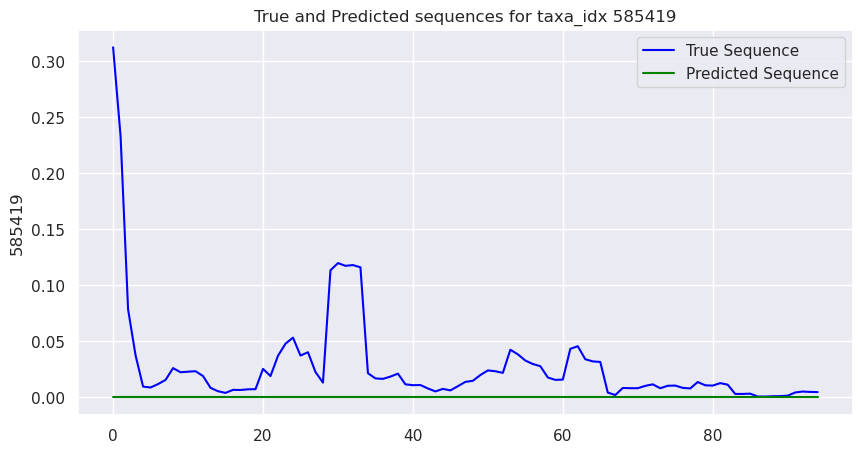

In [20]:
target_taxa = 585419

true_sequence = y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [21]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,253271473.182213,1317367453.079343,120992134.381201,307731046.004672,717797288.711204,10418538.543076,1667536.077973,0.621980,1896327768.609658,0.535133,...,6010131.759258,815789462.792253,542274961.613344,1849624035.455246,322817044.790088,3286438.867257,1041856596.118732,29247530.576919,2730671420.600825,4546250.408337
std,322848336.889615,2502608736.516109,517952391.708826,480815912.428739,888331510.380047,59547471.336979,6873675.220313,0.395707,2068665787.257126,0.498226,...,35538104.938755,603544285.971491,884636828.901074,1369607036.092158,402173072.411843,15529048.661796,698863083.009902,131656265.690559,2587763375.163496,44311356.690783
min,0.000000,170351.944848,0.017705,9569377.862666,0.000000,0.000000,0.070970,0.002192,0.000000,0.024509,...,0.001966,0.000000,0.000000,0.000000,223358.867715,0.022577,0.000000,0.000240,226336.514112,0.008411
25%,6079027.274459,3151510.979694,0.180649,83732056.298325,129733518.604478,0.375797,0.455072,0.322005,134652375.228854,0.202804,...,0.249709,320512816.233516,10113901.663795,714285704.748977,10497866.782623,0.299862,551181095.003148,0.208799,1027341437.553269,0.314422
50%,36474163.646756,142073522.003493,0.464220,153110045.802652,483870961.281565,0.802838,0.758708,0.581797,1602088464.457585,0.360790,...,0.422259,769230758.960437,79225563.033058,1632653039.426234,109892562.915971,0.716040,905511798.933743,0.495599,1804581027.013045,0.677546
75%,449848018.309994,1380872864.940427,0.851096,385167458.972295,1020336592.267648,1.201742,1.143102,0.914064,2829073883.634792,0.750846,...,0.661995,1185897420.064007,531581855.305395,2755102004.031770,560854116.833342,1.127349,1476377933.044146,0.969062,3054184921.424060,1.220593
max,1115501504.863297,9999999866.485682,3448275816.029546,3416267896.971664,5133239763.160954,477815693.279179,39603959.867270,1.878944,9329485997.999146,2.544918,...,277324629.250011,2435897403.374717,3344811764.526360,5510204008.063539,1445355232.986282,106121192.062060,3346456648.233398,766445372.989548,9999999866.485682,431893681.941242


In [2]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=2)

NameError: name 'only_predicted_errors' is not defined

In [23]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,3439402,4473763,175535,3887769,189384,865469,4339832,309391,4345850,682726,...,4419650,1059729,366794,177567,367433,193484,359650,193233,196664,354850
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,120992134.381201,10418538.543076,1667536.077973,0.621980,0.535133,6.195396,1.383271,0.617664,40367909.927974,6.247524,...,0.910134,0.911301,2462296.836001,15245010.394190,20552701.878932,0.463628,6010131.759258,3286438.867257,29247530.576919,4546250.408337
std,517952391.708826,59547471.336979,6873675.220313,0.395707,0.498226,35.029619,1.257831,0.547313,193094055.602657,5.178976,...,0.840715,1.141363,16879695.937266,107491984.181895,197605623.065091,0.290864,35538104.938755,15529048.661796,131656265.690559,44311356.690783
min,0.017705,0.000000,0.070970,0.002192,0.024509,0.000894,0.005157,0.005484,0.002877,0.148630,...,0.024578,0.005043,0.025646,0.000000,0.000000,0.005889,0.001966,0.022577,0.000240,0.008411
25%,0.180649,0.375797,0.455072,0.322005,0.202804,0.288412,0.539550,0.284947,0.197460,2.246655,...,0.440359,0.243853,0.260714,0.163998,0.504804,0.232374,0.249709,0.299862,0.208799,0.314422
50%,0.464220,0.802838,0.758708,0.581797,0.360790,0.600327,0.936091,0.544952,0.407895,5.362049,...,0.708483,0.575421,0.448085,0.548252,0.791034,0.396605,0.422259,0.716040,0.495599,0.677546
75%,0.851096,1.201742,1.143102,0.914064,0.750846,1.452805,1.864015,0.810440,0.694934,8.145520,...,1.000000,0.876803,0.899712,2.150809,1.343265,0.690496,0.661995,1.127349,0.969062,1.220593
max,3448275816.029546,477815693.279179,39603959.867270,1.878944,2.544918,323.569079,6.810089,3.685691,1359223282.823297,19.981736,...,5.307074,5.728087,116959062.765914,896551712.167682,1926121346.315184,1.047101,277324629.250011,106121192.062060,766445372.989548,431893681.941242


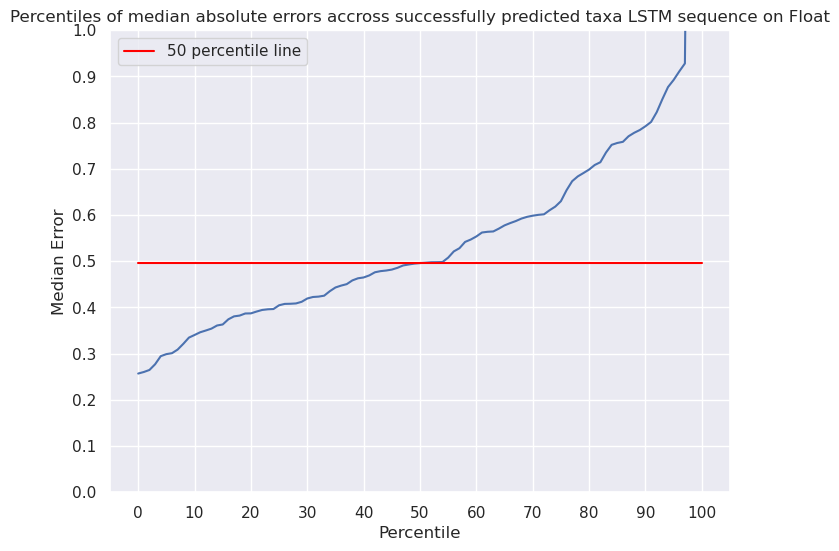

In [24]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa LSTM sequence on Float", y_top_lim=1)